In [2]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\ic2594\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [46]:
df = data.load_asset('ETHUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
df = data.subset(df, pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'))
df['Market Return'] = df['Close'].pct_change()
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category,Market Return
Open time,,,,,,,,,,,,
2022-01-02,3765.54,3857.44,3717.30,3828.27,154791.4263,5.853750e+08,450610,81170.5053,3.070566e+08,29.0,Fear,0.016659
2022-01-03,3828.11,3853.09,3680.00,3765.89,236245.8586,8.929441e+08,594541,114525.6299,4.330844e+08,29.0,Fear,-0.016295
2022-01-04,3765.89,3900.73,3713.11,3785.11,288258.5549,1.098183e+09,676651,147451.4285,5.619582e+08,23.0,Extreme Fear,0.005104
2022-01-05,3785.10,3848.00,3415.00,3540.63,397942.0363,1.464819e+09,962670,183641.1134,6.766633e+08,24.0,Extreme Fear,-0.064590
2022-01-06,3539.82,3550.43,3300.00,3406.81,496745.7413,1.698728e+09,1006279,250536.4828,8.569387e+08,15.0,Extreme Fear,-0.037796
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1228.12,1233.73,1200.58,1211.55,262437.6398,3.191001e+08,372190,129218.2839,1.571326e+08,27.0,Fear,-0.013484
2022-12-28,1211.55,1215.78,1181.06,1190.15,367828.8914,4.398759e+08,474792,178354.6600,2.132696e+08,28.0,Fear,-0.017663
2022-12-29,1190.15,1206.57,1186.77,1200.49,249130.4869,2.982451e+08,377201,123380.9102,1.476923e+08,28.0,Fear,0.008688


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Log = []

def objective(trial, optimal_params=None):
    if trial is not None:
        window = trial.suggest_int('window', 5, 50)
        # threshold = trial.suggest_float('threshold', 0.1, 2.0)
        long = trial.suggest_float('long', 0.1, 2.0)
        short = trial.suggest_float('short', 0.1, 2.0)
        long_exit = trial.suggest_float('long_exit', -0.5, 2.0)
        short_exit = trial.suggest_float('short_exit', -0.5, 2.0)
        # buy_long = trial.suggest_float('buy_long', 0, 1)
        # buy_short = trial.suggest_float('buy_short', 0, 1)

    if optimal_params is not None:
        window = optimal_params['window']
        long = optimal_params['long']
        short = optimal_params['short']
        # buy_long = optimal_params['buy_long']
        # buy_short = optimal_params['buy_short']

    buy_long = buy_short = 1

    # Calculate Moving Average and Standard Deviation
    moving_avg = df['Close'].rolling(window=window).mean()
    moving_std = df['Close'].rolling(window=window).std()
    z_score = (df['Close'] - moving_avg) / moving_std

    long = z_score < -long
    long_exit = z_score > -long_exit
    short = z_score > short
    short_exit = z_score < short_exit

    df['Long'] = False
    df['Short'] = False
    df['Position'] = 0.0



    # Strategy: Buy when Z < -threshold, Sell when Z > threshold
    enter_long = (z_score < -long) & (z_score.shift(1) >= -long)
    enter_long = enter_long[enter_long == True].index
    enter_short = (z_score > short) & (z_score.shift(1) <= short)
    enter_short = enter_short[enter_short == True].index
    exit_long = (z_score > long_exit) & (z_score.shift(1) <= long_exit)
    exit_long = exit_long[exit_long == True].index
    exit_short = (z_score < short_exit) & (z_score.shift(1) >= short_exit)
    exit_short = exit_short[exit_short == True].index

    enter_indices = []
    exit_indices = []

    for (indices, enter, exit, buy, col) in [
        [ enter_indices, enter_long, exit_long, buy_long, 'Long' ],
        [ exit_indices, enter_short, exit_short, buy_short, 'Short' ],
    ]:
        i = 0
        j = 0
        entered = False
        exited = False
        while i < len(enter) and j < len(exit):
            if enter[i] < exit[j]:
                if not entered:
                    enter_indices.append((enter[i], 1))
                    entered = True
                    exited = False
                i += 1
            else:
                if not exited:
                    enter_indices.append((exit[j], 0))
                    exited = True
                    entered = False
                j += 1

        for (thing1, thing2) in zip(indices[0:-1], indices[1:]):
            index1, action1 = thing1
            index2, action2 = thing2
            if action1 == 1 and action2 == 0:
                df.loc[index1:index2, 'Position'] = buy
                df.loc[index1:index2, col] = True


    df['Position'] = df['Position'].shift(1)
    df['Strategy Return'] = df['Position'] * df['Market Return']
    df['Short Strategy Return'] = df['Short'] * df['Position'] * df['Market Return']
    df['Long Strategy Return'] = df['Long'] * df['Position'] * df['Market Return']

    cumulative_returns = (1 + df[['Market Return', 'Strategy Return', 'Long Strategy Return']]).cumprod()
    end_returns = cumulative_returns['Strategy Return'].iloc[-1] - 1
    sharpe_ratio = (cumulative_returns['Strategy Return'].mean() / cumulative_returns['Strategy Return'].std()) * np.sqrt(252)

    return sharpe_ratio, end_returns

def objective_sharpe(trial, optimal_params=None):
    return objective(trial, optimal_params)[0]

def objective_end(trial, optimal_params=None):
    return objective(trial, optimal_params)[1]

In [59]:
np.finfo(np.float64).eps

np.float64(2.220446049250313e-16)

In [51]:
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as vis

study = optuna.create_study(direction='maximize')
for i in range(10):
    study.optimize(objective_end, n_trials=100)
    %store study


[I 2025-04-27 17:15:20,912] A new study created in memory with name: no-name-08fda76d-410d-4627-8d6a-58cc27ac31db
[I 2025-04-27 17:15:20,915] Trial 0 finished with value: -0.3673350024719497 and parameters: {'window': 48, 'long': 1.782125372894848, 'short': 0.33231360256366577}. Best is trial 0 with value: -0.3673350024719497.
[I 2025-04-27 17:15:20,920] Trial 1 finished with value: -0.39275158940697574 and parameters: {'window': 43, 'long': 0.9754892522977625, 'short': 1.7241110180905665}. Best is trial 0 with value: -0.3673350024719497.
[I 2025-04-27 17:15:20,923] Trial 2 finished with value: -0.6109151825597958 and parameters: {'window': 42, 'long': 0.11863964223608608, 'short': 0.4595689677280237}. Best is trial 0 with value: -0.3673350024719497.
[I 2025-04-27 17:15:20,927] Trial 3 finished with value: -0.09879289517615664 and parameters: {'window': 11, 'long': 1.529166006100549, 'short': 1.1506963448550367}. Best is trial 3 with value: -0.09879289517615664.
[I 2025-04-27 17:15:20,

Stored 'study' (Study)


[I 2025-04-27 17:15:21,941] Trial 118 finished with value: 0.10298518178349503 and parameters: {'window': 44, 'long': 1.8322545995573758, 'short': 1.6423668591600102}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:21,951] Trial 119 finished with value: 0.13685681322119314 and parameters: {'window': 50, 'long': 1.9967827181343383, 'short': 1.7619961519460947}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:21,961] Trial 120 finished with value: 0.08206991189298929 and parameters: {'window': 46, 'long': 1.8739492177557662, 'short': 1.8650579848791233}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:21,971] Trial 121 finished with value: 0.20035513431534624 and parameters: {'window': 50, 'long': 1.9538290195499564, 'short': 1.8970873439568243}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:21,982] Trial 122 finished with value: 0.11328215654783702 and parameters: {'window': 48, 'long': 1.958525705980

Stored 'study' (Study)


[I 2025-04-27 17:15:23,025] Trial 217 finished with value: 0.1929879463254227 and parameters: {'window': 43, 'long': 1.939671926398256, 'short': 1.5472563887740147}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:23,036] Trial 218 finished with value: 0.04701952854848401 and parameters: {'window': 43, 'long': 1.8511409211505672, 'short': 1.5731684403065203}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:23,048] Trial 219 finished with value: -0.18704459230512682 and parameters: {'window': 29, 'long': 1.9402385353095082, 'short': 1.5211610683862458}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:23,059] Trial 220 finished with value: 0.10091170139418204 and parameters: {'window': 42, 'long': 1.8964054528202072, 'short': 1.5408541629844417}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:23,070] Trial 221 finished with value: 0.21576016682098165 and parameters: {'window': 43, 'long': 1.9995251745677

Stored 'study' (Study)


[I 2025-04-27 17:15:24,177] Trial 314 finished with value: 0.2514865070353465 and parameters: {'window': 43, 'long': 1.9525549163829903, 'short': 0.7988058430707398}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:24,190] Trial 315 finished with value: -0.20386320202145658 and parameters: {'window': 43, 'long': 1.3403796589017098, 'short': 0.7968630229929116}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:24,202] Trial 316 finished with value: 0.017543445106082745 and parameters: {'window': 43, 'long': 1.9034102533879451, 'short': 0.8456471652162656}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:24,214] Trial 317 finished with value: 0.07360106069577643 and parameters: {'window': 45, 'long': 1.9534043705321318, 'short': 0.624689362303767}. Best is trial 72 with value: 0.2687385966439584.
[I 2025-04-27 17:15:24,226] Trial 318 finished with value: 0.09836047934679382 and parameters: {'window': 44, 'long': 1.846039308671

Stored 'study' (Study)


[I 2025-04-27 17:15:25,472] Trial 413 finished with value: 0.21038280811146381 and parameters: {'window': 44, 'long': 1.9999477244216823, 'short': 0.7108351031966661}. Best is trial 320 with value: 0.30108819886746496.
[I 2025-04-27 17:15:25,488] Trial 414 finished with value: 0.11916755387920053 and parameters: {'window': 42, 'long': 1.8779826838796976, 'short': 0.8260118202443347}. Best is trial 320 with value: 0.30108819886746496.
[I 2025-04-27 17:15:25,501] Trial 415 finished with value: -0.14002648895749326 and parameters: {'window': 7, 'long': 1.9351703929881356, 'short': 0.7783727198471893}. Best is trial 320 with value: 0.30108819886746496.
[I 2025-04-27 17:15:25,515] Trial 416 finished with value: 0.1731276666655639 and parameters: {'window': 45, 'long': 1.965521347905595, 'short': 0.6411782501453447}. Best is trial 320 with value: 0.30108819886746496.
[I 2025-04-27 17:15:25,529] Trial 417 finished with value: 0.06238824082852901 and parameters: {'window': 46, 'long': 1.965228

Stored 'study' (Study)


[I 2025-04-27 17:15:26,920] Trial 513 finished with value: -0.09821627752358741 and parameters: {'window': 46, 'long': 1.8293668331200337, 'short': 0.7545051262546949}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:26,935] Trial 514 finished with value: -0.32269505434962975 and parameters: {'window': 43, 'long': 1.302155300003127, 'short': 0.5450153010655976}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:26,949] Trial 515 finished with value: 0.1785029145415804 and parameters: {'window': 44, 'long': 1.9314884290787548, 'short': 0.8388266880260624}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:26,964] Trial 516 finished with value: 0.1731276666655639 and parameters: {'window': 46, 'long': 1.9992176899928567, 'short': 0.6260046767134128}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:26,977] Trial 517 finished with value: 0.30108819886746496 and parameters: {'window': 45, 'long': 1.964382492

Stored 'study' (Study)


[I 2025-04-27 17:15:28,430] Trial 612 finished with value: 0.11704143628583963 and parameters: {'window': 46, 'long': 1.9345992678502535, 'short': 0.7980927558955049}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:28,446] Trial 613 finished with value: 0.13356690614412492 and parameters: {'window': 48, 'long': 1.9993513359810544, 'short': 0.7661600458647218}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:28,462] Trial 614 finished with value: 0.2514865070353465 and parameters: {'window': 43, 'long': 1.9635709880611554, 'short': 0.8614782221286381}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:28,479] Trial 615 finished with value: -0.059056727568428946 and parameters: {'window': 44, 'long': 1.8846745557772693, 'short': 0.7046786947015846}. Best is trial 467 with value: 0.3026481531097942.
[I 2025-04-27 17:15:28,498] Trial 616 finished with value: 0.15274354253598776 and parameters: {'window': 45, 'long': 1.9331155

Stored 'study' (Study)


[I 2025-04-27 17:15:30,084] Trial 712 finished with value: 0.11127554610219015 and parameters: {'window': 41, 'long': 1.9385189364122166, 'short': 1.0061351573356512}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:30,101] Trial 713 finished with value: 0.00836546103866942 and parameters: {'window': 43, 'long': 1.8062440640451571, 'short': 1.1879176794022686}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:30,118] Trial 714 finished with value: 0.33769559980829644 and parameters: {'window': 44, 'long': 1.9338643212038649, 'short': 1.146912113018397}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:30,134] Trial 715 finished with value: 0.1189163960972508 and parameters: {'window': 43, 'long': 1.8709221401868725, 'short': 1.1444119625181475}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:30,151] Trial 716 finished with value: -0.2165897946074824 and parameters: {'window': 44, 'long': 1.896403

Stored 'study' (Study)


[I 2025-04-27 17:15:31,782] Trial 810 finished with value: 0.0915348249554071 and parameters: {'window': 41, 'long': 1.9023847389380377, 'short': 1.1598060136218769}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:31,800] Trial 811 finished with value: -0.21400209968963702 and parameters: {'window': 39, 'long': 1.8056462951124366, 'short': 1.2010405462259444}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:31,818] Trial 812 finished with value: 0.13917042262833812 and parameters: {'window': 38, 'long': 1.8487678177231954, 'short': 1.0710376097459389}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:31,835] Trial 813 finished with value: 0.1469246680991898 and parameters: {'window': 42, 'long': 1.9122736646615492, 'short': 1.1232038074229271}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:31,853] Trial 814 finished with value: 0.08670628597502783 and parameters: {'window': 42, 'long': 1.90516

Stored 'study' (Study)


[I 2025-04-27 17:15:33,631] Trial 910 finished with value: -0.014193178163515618 and parameters: {'window': 44, 'long': 1.9632340209949177, 'short': 1.2840539671627917}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:33,652] Trial 911 finished with value: 0.33769559980829644 and parameters: {'window': 44, 'long': 1.9570470246056293, 'short': 1.151112640817504}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:33,671] Trial 912 finished with value: 0.23845499315857688 and parameters: {'window': 44, 'long': 1.9628756287512765, 'short': 1.1620102709324696}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:33,690] Trial 913 finished with value: 0.13769192647199646 and parameters: {'window': 44, 'long': 1.9661111968315303, 'short': 1.2047840553392006}. Best is trial 643 with value: 0.43516316526215126.
[I 2025-04-27 17:15:33,708] Trial 914 finished with value: 0.3286916606968686 and parameters: {'window': 43, 'long': 1.9565

Stored 'study' (Study)


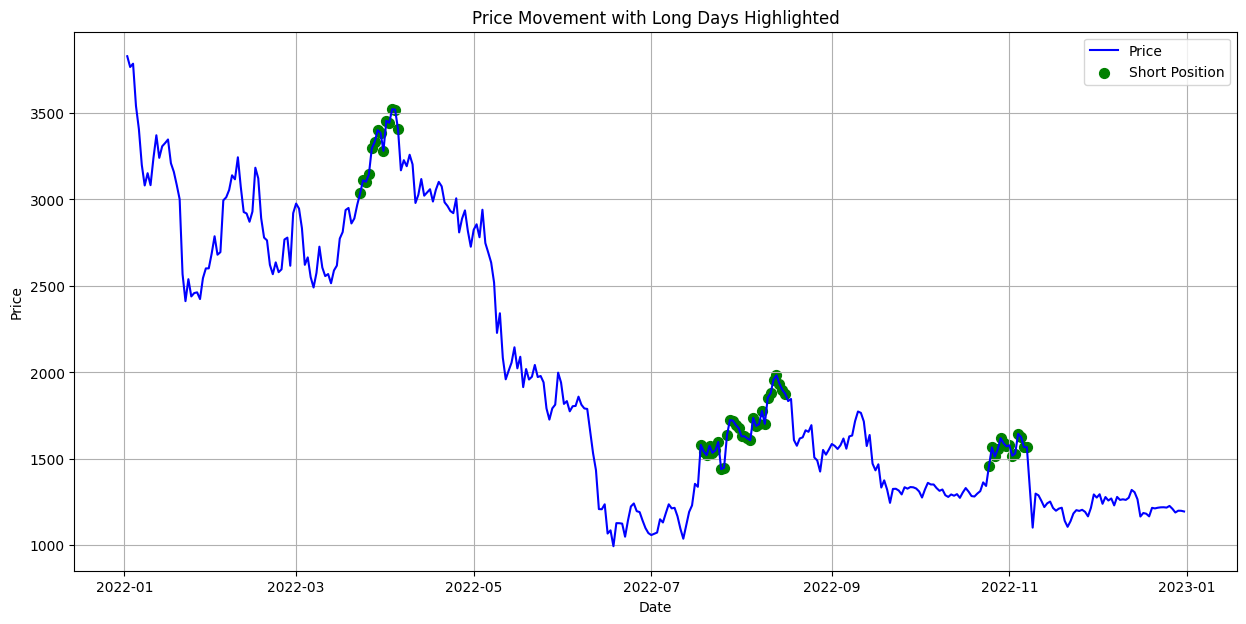

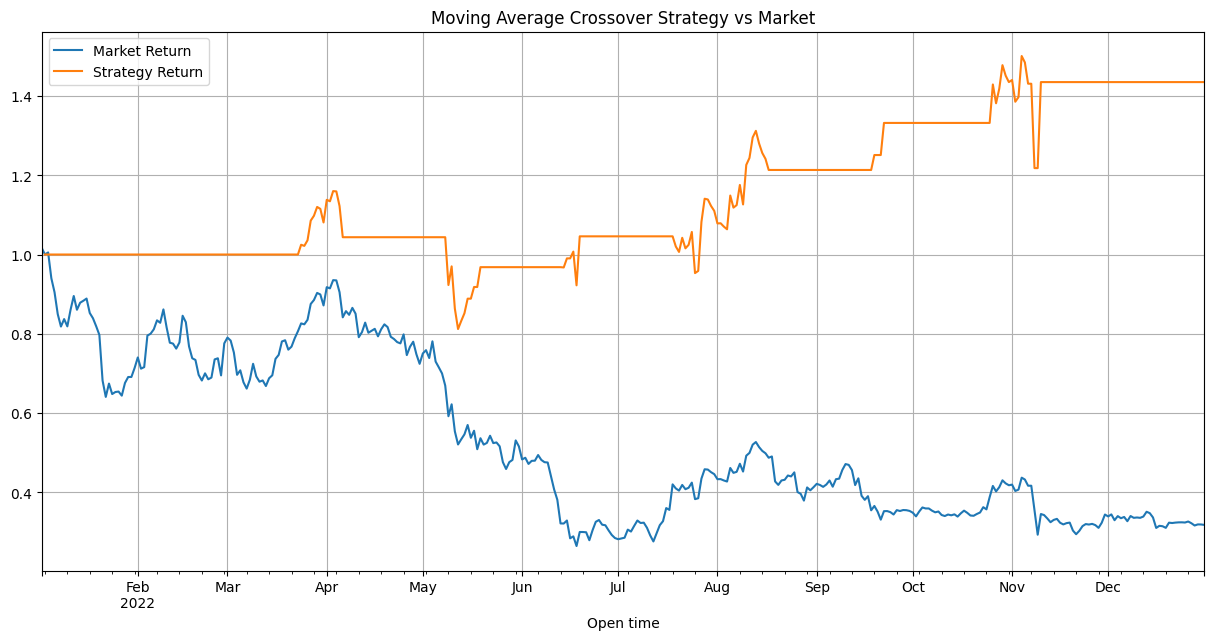

In [52]:
# Use optimal parameters from the best trial
optimal_params = study.best_trial.params
# optimal_params = {'window': 30, 'long': 1.4193168202203523, 'short': 1.0111870832321064, 'buy_long': 0.9804809925178282, 'buy_short': 0.9994090685190979}
objective(None, optimal_params=optimal_params)

# Plot setup
plt.figure(figsize=(15,7))

# Plot price
plt.plot(df.index, df['Close'], label='Price', color='blue')

# Highlight long days
long_days = df['Long'] == True
short_days = df['Short'] == True
plt.scatter(df.index[short_days], df['Close'][short_days], 
            label='Short Position', color='green', marker='o', s=50)

# Titles and labels
plt.title('Price Movement with Long Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

price = df['Close']

# # Calculate Moving Average
# window = 20  # e.g., 50 days
# sma = price.rolling(window=window).mean()

# # Trading signals
# df['Position'] = 0
# df['SMA'] = sma

# # Buy signal: price crosses above SMA
# df.loc[price > sma, 'Position'] = 1

# # Sell signal: price crosses below SMA
# df.loc[price <= sma, 'Position'] = 0

# # Shift position for returns
# df['Position'] = df['Position'].shift(1)

# # Returns
# df['Market Return'] = price.pct_change()
# df['Strategy Return'] = df['Position'] * df['Market Return']

# Plot cumulative returns
(1 + df[['Market Return', 'Strategy Return']]).cumprod().plot(figsize=(15,7))
plt.title('Moving Average Crossover Strategy vs Market')
plt.grid(True)
plt.show()


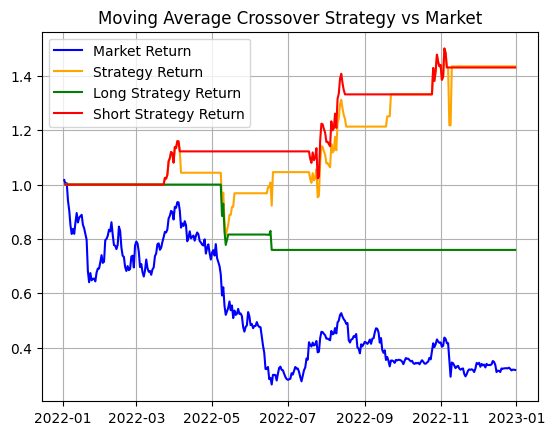

In [53]:
strat = (1 + df[['Market Return', 'Strategy Return']]).cumprod()
long_strat = (1 + df[['Market Return', 'Long Strategy Return']]).cumprod()
short_strat = (1 + df[['Market Return', 'Short Strategy Return']]).cumprod()

plt.plot(strat.index, strat['Market Return'], label='Market Return', color='blue')
plt.plot(strat.index, strat['Strategy Return'], label='Strategy Return', color='orange')
plt.plot(long_strat.index, long_strat['Long Strategy Return'], label='Long Strategy Return', color='green')
plt.plot(short_strat.index, short_strat['Short Strategy Return'], label='Short Strategy Return', color='red')
plt.title('Moving Average Crossover Strategy vs Market')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# Extract trial parameters and results
trials_data = [
    {**trial.params, 'score': trial.value}
    for trial in study.trials
]

# Convert to a DataFrame
trials_df = pd.DataFrame(trials_data)

# Display the DataFrame
trials_df.sort_values(by="score", ascending=False)

,window,long,short,score
979,43,1.998246,1.093102,0.435163
954,43,1.976879,1.124498,0.435163
958,44,1.967671,1.126513,0.435163
953,44,1.971274,1.122439,0.435163
959,44,1.997968,1.082575,0.435163
...,...,...,...,...
382,46,0.265628,0.725572,-0.552820
627,45,0.159925,0.677771,-0.553744
8,11,0.185033,1.846380,-0.592866
2,42,0.118640,0.459569,-0.610915


In [8]:
trials_df.mean(), trials_df.std()

(window    33.214000
 long       1.353418
 short      0.808929
 score      2.408097
 dtype: float64,
 window    5.128597
 long      0.286598
 short     0.271549
 score     0.834222
 dtype: float64)

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.array([list(t.params.values()) for t in study.trials if t.value is not None])
y = np.array([t.value for t in study.trials if t.value is not None])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(X_scaled, y)

print("Learned kernel:", gp.kernel_)




Learned kernel: 1.22**2 * RBF(length_scale=0.42) + WhiteKernel(noise_level=0.109)


#### Interpretation from ChatGPT:
length-scale: 0.904, noise_level: 0.192
 - ~0.904 std-dev in the input space corresponds to significant change in predicted score.
 - about 19.2% of score variation is due to "noise"